# Depth Monte Carlo & Mocks
(c) Ashley Ross, Anand Raichoor, Julian Bautista, Lado Samushia, 

import required modules

In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from time import time
%matplotlib inline


## desitarget on Mehdi's local
#from desitarget.cuts import isELG_colors
# to work on Mehdi's local pc
from cuts import isELG_colors as colorcuts_function
#colorcuts_function = cuts.isELG_colors 

In [2]:
plt.rc('font', family='serif', size=20)

## Part 1: MC to get N(z) given depth_g,r,z
### Parameters
Here we define the redshift range of interest, 3D grid of depth-grz, ...

In [3]:
# Parameters you may want to change are in the first five cells
south=True

# Redshift binning
z_bin_width = 0.05
z_min = 0.6
z_max = 2.0
Nzb   = int((z_max*1.001 - z_min)/z_bin_width)
z_bin_edge = np.linspace(z_min, z_max, Nzb + 1) #bin edges for histogram, so Nb +1
z_bin_mid = np.arange(z_min + z_bin_width/2.0, z_max, z_bin_width) #bin centers
#z_bin_mid = 0.5*(z_bin_edge[1:]+z_bin_edge[:-1]) ## MR: how about this one?


# Grid in color depth space
gsig  = np.arange(0.01, 0.14, 0.01)
rsig  = np.arange(0.01, 0.14, 0.01)
zsig  = np.arange(0.04, 0.30, 0.01)
Ngsig = np.size(gsig)
Nrsig = np.size(rsig)
Nzsig = np.size(zsig)

# Array to hold n(z) values for each z and depth triplet
nzgrz = np.zeros((Nzb, np.size(gsig), np.size(rsig), np.size(zsig)))

# How many times do we sample each point in depth space?
Nsamples = 10

# Input files
# deep DECaLS imaging, with photozs from HSC
#truthf = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' 
truthf = '/home/mehdi/data/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' ## Mehdi's local pc

### Read
Read the truth catalog, drop the faulty magnitudes, and transfer them to fluxes

In [4]:
# Read the deep imaging catalog
truth  = fitsio.read(truthf,1)

# Get magnitudes, fluxes, photoz
gmag  = truth["g"]
rmag  = truth["r"]
zmag  = truth["z"]
photz = truth['hsc_mizuki_photoz_best']
print('photo_z range : ', photz.min(), photz.max())

# remove faulty magnitudes
good_mag = np.isfinite(gmag)
good_mag &= np.isfinite(rmag)
good_mag &= np.isfinite(zmag)

gmag  = gmag[good_mag]
rmag  = rmag[good_mag]
zmag  = zmag[good_mag]
photz = photz[good_mag]

# remove shallow areas
good_mag = gmag < 24.5
gmag  = gmag[good_mag]
rmag  = rmag[good_mag]
zmag  = zmag[good_mag]
photz = photz[good_mag]

gflux = 10**(-0.4*(gmag-22.5))
rflux = 10**(-0.4*(rmag-22.5))
zflux = 10**(-0.4*(zmag-22.5))

#gflux = gflux[:,np.newaxis]
#rflux = rflux[:,np.newaxis]
#zflux = zflux[:,np.newaxis]

photo_z range :  0.0 6.68


### ELG selection and N(z)
Define a function to perform the ELG selection for a given set of fluctuations in r,g and z fluxes. Another function computes the N(z) after the selection.

In [5]:
def ELGsel(gsig,rsig,zsig,south=True,snrc=True):
    '''
    calculate the ELG selection for given g,r,z flux uncertainties and a given region's selection
    snrc can be toggled for the total signal to noise cut; tests suggest it is indeed necessary
    '''
    grand = np.random.normal(size=gflux.shape)
    rrand = np.random.normal(size=rflux.shape)
    zrand = np.random.normal(size=zflux.shape)
    mgflux = gflux + grand*gsig
    mrflux = rflux + rrand*rsig
    mzflux = zflux + zrand*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2) #combined signal to noise; tractor ignores anything < 6
    
    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=None, w2flux=None, south=south) 
    if snrc:
        selection *= ( combined_snr > 6 ) * ( mgflux > 4*gsig ) * ( mrflux > 3.5*rsig ) * ( mzflux > 2.*zsig )
    return selection

In [6]:
def getnz(sigg,sigr,sigz):
    '''
    Number of galaxies in each redshift bin after adding some noise.
    '''
    sel = ELGsel(sigg,sigr,sigz,south=south)
    nztest = np.histogram(photz[sel], range=(z_min,z_max), bins=z_bin_edge)
    return nztest[0]

### Run the MC on the grid

Find n(z) for different values of depth in g,r,z

In [7]:
##  Approach 1: vectorized numpy, requires gflux = gflux[:,np.newaxis]
##  The average over Nsamples is
#
#  MR: this is 1.4x faster that than 'for' loops
#
# # gg, rr, zz = np.meshgrid(gsig, rsig, zsig)
# # t1 = time()
# # NZ = ELGsel(gg.ravel(), rr.ravel(), zz.ravel())
# # t2 = time()
# # t2-t1
# t0 = time()
# dNz = np.column_stack([np.histogram(photz[NZ[:,i]], bins=z_bin_edge)[0] for i in range(NZ.shape[1])])
# t1 = time()
# t1-t0
# nzgrz = dNz.reshape((16, 13, 13, 26))


# Find n(z) for different values of depth in g,r,z
k = 0
t0=time()
total = Ngsig*Nrsig*Nzsig
for ig, ir, iz in product(range(Ngsig), range(Nrsig), range(Nzsig)):
    nz_subsampled = np.zeros((Nsamples,Nzb))
    for i in range(Nsamples):
        nz_sub = getnz(gsig[ig], rsig[ir], zsig[iz])
        nz_subsampled[i,:] = nz_sub
    nzgrz[:, ig, ir, iz] = np.mean(nz_subsampled, axis=0)
    if k%1000==0:
        print('{}/{} in {} sec'.format(k, total, time()-t0))
    k+=1

0/4394 in 0.48409581184387207 sec
1000/4394 in 351.97558331489563 sec
2000/4394 in 705.3319709300995 sec
3000/4394 in 1059.3849968910217 sec
4000/4394 in 1414.4147713184357 sec


save the Nz

In [8]:
np.save('nz_grz.npy',nzgrz)

## Explore the N(z)

In [9]:
nzgrz = np.load('nz_grz.npy')

In [10]:
nzgrz.shape

(28, 13, 13, 26)

`nzgrz` is a multidimensional array, respectively the axes are for the redshift, depth-g, r, and z.

### relative N(z) at Z = 0.9

The 6th element is z = 0.9

In [11]:
z_bin_mid[6]

0.9250000000000003

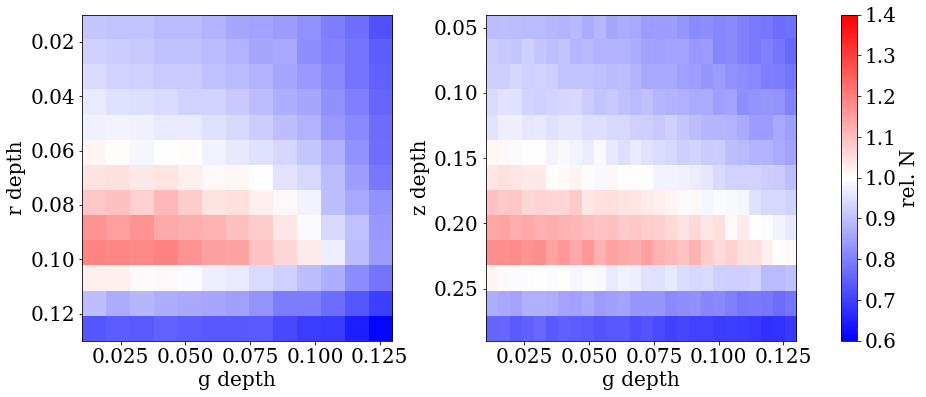

In [12]:
# figure
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.3)
kw   = dict(vmin=0.6, vmax=1.4, aspect='auto', 
            interpolation='none', cmap=plt.cm.bwr)

# depth-g vs depth-r
map1 = ax[0].imshow(nzgrz[6,:,:, 10]/nzgrz[6,6,6,13],
                    extent=[0.01, 0.13, 0.13, 0.01], **kw)

# depth-g vs depth-z
map2 = ax[1].imshow(nzgrz[6,:,6, :]/nzgrz[6,6,6,13], 
                    extent=[0.01, 0.13, 0.29, 0.04], **kw)

# annotation
ax[0].set(xlabel='g depth', ylabel='r depth')
ax[1].set(xlabel='g depth', ylabel='z depth')
fig.colorbar(map1, ax=ax, label='rel. N')

### rel N(z) vs z

Text(0, 0.5, 'number ratio')

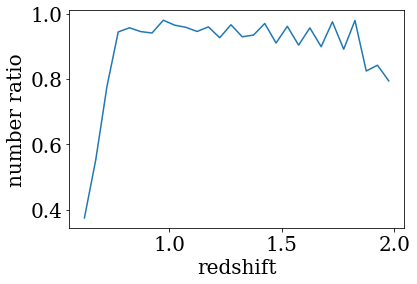

In [13]:
plt.plot(z_bin_mid, nzgrz[:,3,3,10]/nzgrz[:,6,6,13])
plt.xlabel('redshift')
plt.ylabel('number ratio')

## Part 2: Associate the N(z)s to the Imaging maps

Read the imaging attributes in Healpix, and evaluate the fluctuations in depth_r,g,z of the pixels.

In [14]:
#read in DR8 properties map
#pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pixfn      = '/home/mehdi/data/pixweight-dr8-0.31.1.fits' # Mehdi's local pc
pix,header = fitsio.read(pixfn,header=True)
HPXNSIDE   = header["HPXNSIDE"]
ii = np.where((pix["GALDEPTH_G"]>0)&(pix["GALDEPTH_R"]>0)&(pix["GALDEPTH_Z"]>0)&(pix["FRACAREA"]>0.01))[0]
npix=ii.size

print('nside=', HPXNSIDE)
print('columns=', pix.dtype.names)
print('number of pixels (before cut)=', pix.size)
print('number of pixels (after cut) =', npix)
pix = pix[ii]

depth_keyword="PSFDEPTH"
# gdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_G"]))+22.5
# rdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_R"]))+22.5
# zdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_Z"]))+22.5


R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211
gsigma=1./np.sqrt(pix[depth_keyword+"_G"])
rsigma=1./np.sqrt(pix[depth_keyword+"_R"])
zsigma=1./np.sqrt(pix[depth_keyword+"_Z"])


Gsig = gsigma*10**(0.4*R_G*pix["EBV"])
Rsig = rsigma*10**(0.4*R_R*pix["EBV"])
Zsig = zsigma*10**(0.4*R_Z*pix["EBV"])

nside= 256
columns= ('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')
number of pixels (before cut)= 786432
number of pixels (after cut) = 374065


Use KDTree to find the closest grid points to each observation

In [15]:
from sklearn.neighbors import KDTree

In [16]:
t0 = time()

position_grz = np.column_stack([Gsig, Rsig, Zsig])

# prepare the grid points
GRZsig_grid  = np.meshgrid(gsig, rsig, zsig)
GRZsig_grid  = np.column_stack([GRZsig_grid[i].ravel() for i in range(3)]) # 3: r, g, z
print(GRZsig_grid.shape)

MyTree    = KDTree(GRZsig_grid, leaf_size=3)
dist, ind = MyTree.query(position_grz)
ind       = ind.flatten()

# reshape except the first axis ie. redshift
mynzrgz = nzgrz.reshape(nzgrz.shape[0], -1) 

# assign the N(z)
Nz_at_pos = mynzrgz[:, ind]

print(time()-t0, 'sec')

(4394, 3)
0.730694055557251 sec


In [17]:
Nz_at_pos, Nz_at_pos.shape

(array([[ 34.2,  39.2,  35.4, ...,  77.8,  77.8,  52.1],
        [ 71.5,  77.3,  71.7, ..., 130.7, 130.7,  93.6],
        [128.2, 136.7, 127.9, ..., 161.4, 161.4, 148. ],
        ...,
        [ 81.6,  82.6,  82. , ...,  94.7,  94.7,  88.3],
        [ 53.1,  54.3,  56.6, ...,  63.2,  63.2,  59.4],
        [ 58.7,  60.5,  61. , ...,  73.1,  73.1,  65.8]]), (28, 374065))

look at the distributions of the depth_rgz

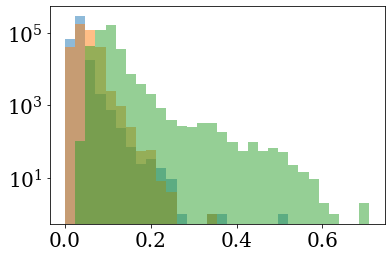

In [18]:
plt.hist(Gsig, range=(0., 0.71), bins=30, alpha=0.5)
plt.hist(Rsig, range=(0., 0.71), bins=30, alpha=0.5)
plt.hist(Zsig, range=(0., 0.71), bins=30, alpha=0.5)
plt.yscale('log')

Find the median N(z) for the depth using 10xNsamples

In [19]:
depth_medians = (np.median(Gsig), np.median(Rsig), np.median(Zsig))
print('depth_medians = ', depth_medians)

Nz_median = []
for _ in range(10*Nsamples):
    Nz_median.append(getnz(*depth_medians))
    
Nz_median = np.median(np.array(Nz_median), axis=0)

depth_medians =  (0.029414529, 0.045621302, 0.09792265)


In [20]:
np.save('nz_median.npy', Nz_median)

Text(0, 0.5, 'median N(z)')

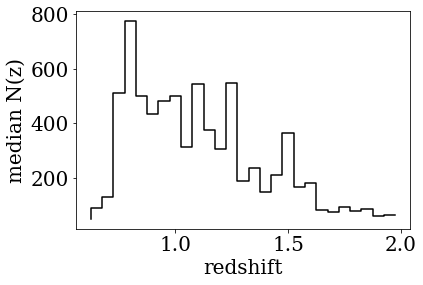

In [21]:
plt.step(z_bin_mid, Nz_median, 'k-')
plt.xlabel('redshift')
plt.ylabel('median N(z)')

In [22]:
output = np.empty(pix['HPXPIXEL'].size, dtype=[('HPIXPIXEL', 'int32'),
                                               ('deltaNz', ('f8', Nz_at_pos.shape[0]))])
output['HPIXPIXEL'] = pix['HPXPIXEL']
output['deltaNz']   = Nz_at_pos.T/Nz_median-1.0 # reshape to [# pix, # z bins]
fitsio.write('deltaNz_pixweight-dr8-0.31.1.fits', output, clobber=True)

In [23]:
output

array([(     0, [-0.316     , -0.21428571, -0.02878788,  0.07363281,  0.06606335,  0.03692615,  0.02045977,  0.02291667,  0.03727455,  0.03949045,  0.03041475,  0.05626667,  0.05374593,  0.04754098,  0.03989362,  0.05010616,  0.05202703,  0.05428571,  0.04972527,  0.01636364,  0.01803279, -0.01097561,  0.00810811, -0.02391304, -0.0675    , -0.05116279, -0.1       , -0.11060606]),
       (     1, [-0.216     , -0.15054945,  0.03560606,  0.05273438,  0.04175824,  0.03732535,  0.02045977,  0.03333333,  0.02685371,  0.0388535 ,  0.02930876,  0.0488    ,  0.03289902,  0.03187614,  0.03670213,  0.05180467,  0.06554054,  0.04190476,  0.05934066,  0.01757576,  0.01857923, -0.01463415,  0.03243243, -0.06521739, -0.04875   , -0.03953488, -0.07966102, -0.08333333]),
       (     2, [-0.292     , -0.21208791, -0.03106061,  0.05683594,  0.04925663,  0.03173653,  0.03195402,  0.03354167,  0.0498998 ,  0.03343949,  0.03539171,  0.02853333,  0.01726384,  0.04262295,  0.04095745,  0.05392781,  0.060810

### Visual inspection of the output

Let's plot some of these $\Delta$N(z)s. We need to read `pixweight-dr8-0.31.1.fits` again (assuming the jupyter kernel is restarted).

In [24]:
filename = 'deltaNz_pixweight-dr8-0.31.1.fits'
DeltaNz  = fitsio.read(filename)
print('Columns in {} : {}'.format(filename, DeltaNz.dtype))
      
# read in DR8 properties map
#pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pixfn      = '/home/mehdi/data/pixweight-dr8-0.31.1.fits' # Mehdi's local pc
pix,header = fitsio.read(pixfn,header=True)
HPXNSIDE   = header["HPXNSIDE"]
ii = np.where((pix["GALDEPTH_G"]>0)&(pix["GALDEPTH_R"]>0)&(pix["GALDEPTH_Z"]>0)&(pix["FRACAREA"]>0.01))[0]
npix=ii.size

print('nside=', HPXNSIDE)
print('columns=', pix.dtype.names)
print('number of pixels (before cut)=', pix.size)
print('number of pixels (after cut) =', npix)
pix = pix[ii]

depth_keyword="PSFDEPTH"

R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
gsigma=1./np.sqrt(pix[depth_keyword+"_G"])
Gsig = gsigma*10**(0.4*R_G*pix["EBV"])

Columns in deltaNz_pixweight-dr8-0.31.1.fits : [('HPIXPIXEL', '>i4'), ('deltaNz', '>f8', (28,))]
nside= 256
columns= ('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')
number of pixels (before cut)= 786432
number of pixels (after cut) = 374065


We split the Healpix pixels into percentiles of `Gsig`

In [25]:
np.percentile(Gsig, [25., 50., 75.])

array([0.02531462, 0.02941453, 0.03919009])

In [26]:
sample1 = Gsig < 0.025
sample2 = (~sample1) & (Gsig < 0.029)
sample3 = (~sample1) & (~sample2) & (Gsig < 0.039)
sample4 = (~sample1) & (~sample2) & (~sample3)

tot = 0
print('tot, Gsig[s_i].min(), Gsig[s_i].max()')
for s_i in [sample1, sample2, sample3, sample4]:
    tot += s_i.sum()
    print(tot, Gsig[s_i].min(), Gsig[s_i].max())

tot, Gsig[s_i].min(), Gsig[s_i].max()
87645 0.012456154 0.02499998
178338 0.025000103 0.028999995
278598 0.029000016 0.0389998
374065 0.03900008 0.497326


[Text(0, 0.5, '$\\delta$N(z)'), Text(0.5, 0, 'z')]

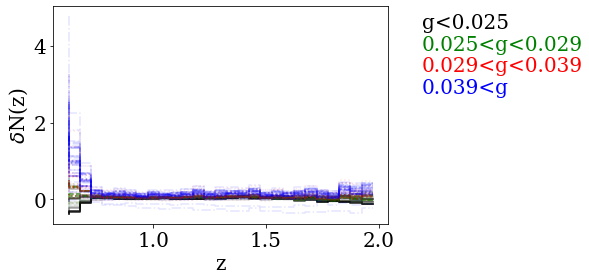

In [29]:
fig, ax = plt.subplots()
c = ['k', 'g', 'r', 'b']
l = ['g<0.025', '0.025<g<0.029',
     '0.029<g<0.039', '0.039<g']
ls = ['-', '--', ':', '-.']
for i,s_i in enumerate([sample1, sample2, sample3, sample4]):
    hpix     = np.argwhere(s_i).flatten()                     # pixel indices of each sample
    hpix_i   = np.random.choice(hpix, size=50, replace=False) # 50 samples of the pixels
    DeltaN_i = DeltaNz['deltaNz'][hpix_i, :]
    for j in range(DeltaN_i.shape[0]):
        if j==DeltaN_i.shape[0]-1:
            ax.text(1.1, 0.9-0.1*i, l[i], color=c[i], transform=ax.transAxes)
        ax.step(z_bin_mid, DeltaN_i[j,:], alpha=0.1, color=c[i],
               linestyle=ls[i])
ax.set(ylabel=r'$\delta$N(z)', xlabel='z')

## Below this part is incomplete
Idea: split the mock catalog into two samples; take one as a `reservoir` in case we need to do up-sampling (ie. $\Delta$N(z)>0).
## Part 3: Up/Down Sample Mock galaxies

In [6]:
import healpy as hp

In [7]:
def project2hp(nside, ra, dec):
    pix  = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    npix = 12*nside*nside
    return np.bincount(pix, minlength=npix)

In [3]:
catalog = fitsio.read('/C/sheejong/Shared/FA_EZmock_desi_ELG_v0_100.fits')
catalog.dtype, catalog.size

(dtype([('RA', '>f8'), ('DEC', '>f8'), ('Z_COSMO', '>f4'), ('DZ_RSD', '>f4'), ('Z', '>f4'), ('PASS', '>i8'), ('epoch', '>i8'), ('year', '>i8'), ('TARGETID', '>i8')]),
 34639280)

In [4]:
catalog['Z_COSMO'].max()

1.907503

In [14]:
index = np.random.choice(np.arange(catalog.size), size=catalog.size//2, replace=False)
cat_mask = np.zeros(catalog.size, '?')
cat_mask[index] = True
catalog1 = catalog[cat_mask]
catalog2 = catalog[~cat_mask]

In [19]:
DeltaN = fitsio.read('deltaNz_pixweight-dr8-0.31.1.fits')

In [23]:
DeltaNint = np.floor(DeltaN['deltaNz'])
DeltaNhpix= DeltaN['HPIXPIXEL']

In [27]:
DeltaNint.sum(axis=0)

array([10550562., 11163955.,  9251337., 16635697., 21204482., 14052411.,
        8781362.,  7463319.,  9994772.,  6020414., 10618327.,  8545262.,
        9802505., 10617691.,  4724068.,  5939104.])

In [46]:
cat2_hpix = hp.ang2pix(256, 
                       np.radians(90-catalog2['DEC']), 
                       np.radians(catalog2['RA']))
cat1_hpix = hp.ang2pix(256, 
                       np.radians(90-catalog1['DEC']), 
                       np.radians(catalog1['RA']))

In [48]:
pix_i     = DeltaNhpix[187648]  # healpix pixel
cat2_pix_i = catalog2[cat2_hpix == pix_i]
cat1_pix_i = catalog1[cat1_hpix == pix_i]
#print(cat_pix_i)

#     cat1_pix_i = 

# catalog['Z_COSMO'].max(), z_bin_edge

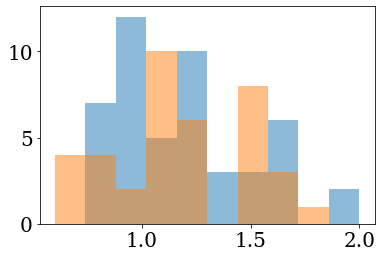

In [51]:
_=plt.hist(cat1_pix_i['Z_COSMO'], alpha=0.5, range=(0.6, 2.0))
_=plt.hist(cat2_pix_i['Z_COSMO'], alpha=0.5, range=(0.6, 2.0))

In [ ]:
DeltaNint.mean(axis=1)

In [ ]:
class MockIt(object):
    def __init__(self):
        

In [9]:
hpind = project2hp(256, catalog['RA'], catalog['DEC'])

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


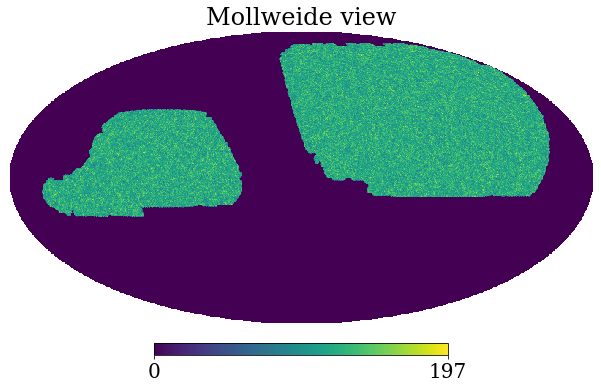

In [10]:
hp.mollview(hpind, rot=-90)

(array([      0.,   47356., 1760030., 3035576., 3273597., 3142106.,
        2862350., 2549331., 2241412., 1982233., 1756917., 1554194.,
        1379078., 1226352., 1092809.,  975437.]),
 array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
        1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 ]),
 <a list of 16 Patch objects>)

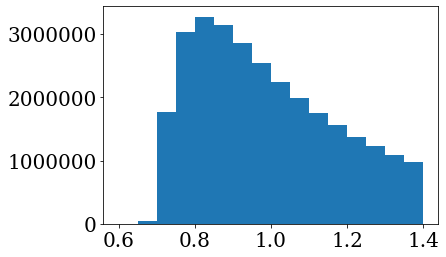

In [11]:
plt.hist(catalog['Z_COSMO'], bins=z_bin_edge)

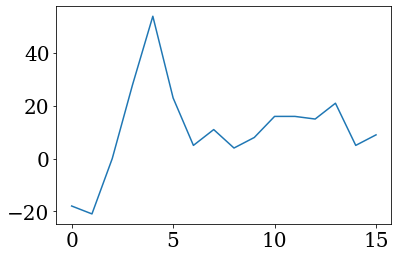

In [63]:
plt.plot(DeltaNint[0,:])
plt.show()